In [1]:
from simple_multi_unet_model import multi_unet_model 

from keras.utils import normalize
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt


IMG_HEIGHT = 128
IMG_WIDTH  = 128
IMG_CHANNELS = 1
n_classes = 3

def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

model = get_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.load_weights('multiclass.hdf5')

In [2]:
from PIL import Image

test_img = cv2.imread('C:/Users/lucyh/Desktop/Images/Filopodia/images/Mock 2 T0_0002.tif_#path1298.tiff',0)
test_img = cv2.resize(test_img, (IMG_HEIGHT, IMG_WIDTH))
test_img = np.array(test_img, dtype=float)
test_img = np.expand_dims(test_img, axis=2)
test_img = test_img.astype(float)
test_img = normalize(test_img, axis=1)
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)

prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]

1/1 [==============================] - 1s 888ms/step


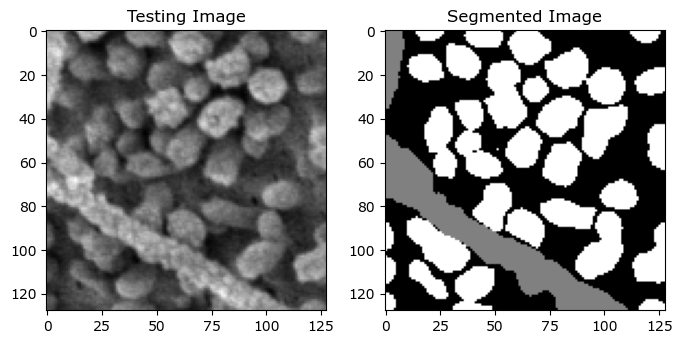

In [3]:
# print testing and segmented image
plt.figure(figsize=(8, 8))
plt.subplot(221)
plt.title('Testing Image')
plt.imshow(test_img, cmap='gray')
plt.subplot(222)
plt.title('Segmented Image')
plt.imshow(predicted_img, cmap='gray')
plt.show()

# save U-NET segmented image
plt.imsave('C:/Users/lucyh/Desktop/Images/Filopodia/output.jpg', predicted_img, cmap='gray')

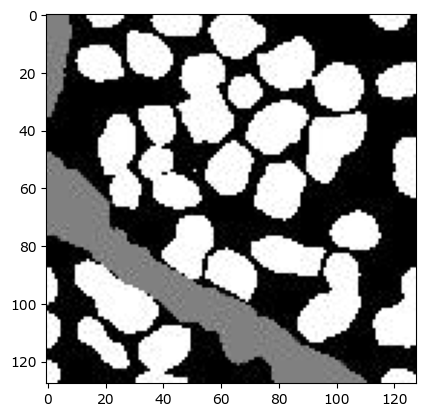

In [37]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage as ndi

from skimage import (
    color, feature, filters, measure, morphology, segmentation, util
)
from skimage.data import human_mitosis

# import U-NET segmented images
image = cv2.imread('C:/Users/lucyh/Desktop/Images/Filopodia/output.jpg')
image = image[:,:,0]

fig, ax = plt.subplots()
ax.imshow(image, cmap='gray')
plt.show()

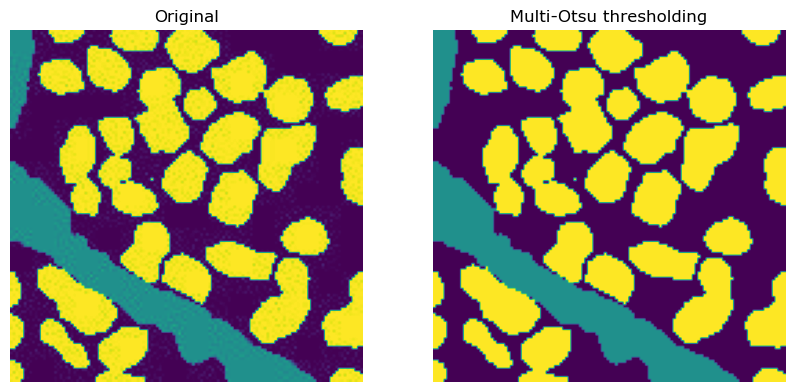

In [38]:
# Otsu thresholding
thresholds = filters.threshold_multiotsu(image, classes=3)
regions = np.digitize(image, bins=thresholds)

fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
ax[0].imshow(image)
ax[0].set_title('Original')
ax[0].axis('off')
ax[1].imshow(regions)
ax[1].set_title('Multi-Otsu thresholding')
ax[1].axis('off')
plt.show()

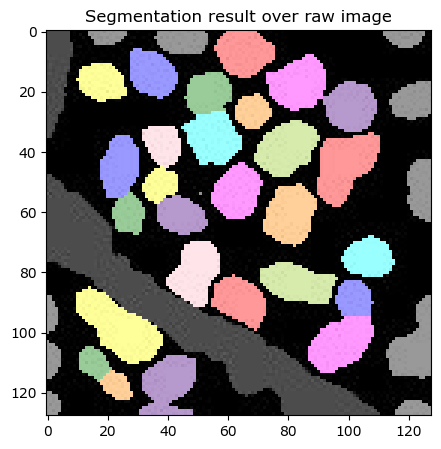

27


In [24]:
# count lamellipodia 
lamellipodia = image > thresholds[1]

# watershed segmentation 
distance = ndi.distance_transform_edt(lamellipodia)

local_max_coords = feature.peak_local_max(distance, min_distance=5)
local_max_mask = np.zeros(distance.shape, dtype=bool)
local_max_mask[tuple(local_max_coords.T)] = True
markers = measure.label(local_max_mask)

segmented_cells = segmentation.watershed(-distance, markers, mask=lamellipodia)

# visualize number of lamellipodia
color_labels = color.label2rgb(segmented_cells, image, alpha=0.4, bg_label=0)

fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(color_labels)
ax.set_title('Segmentation result over raw image')
plt.show()

# number of lamellipodia
print(segmented_cells.max())

number of detected maxima locations 40.0


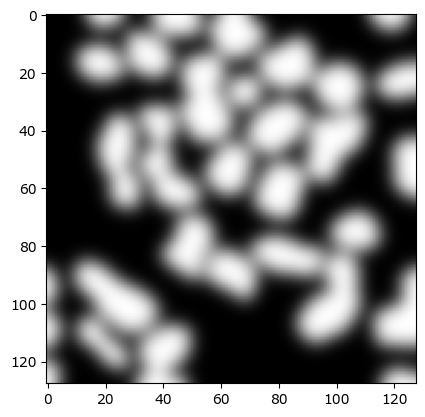

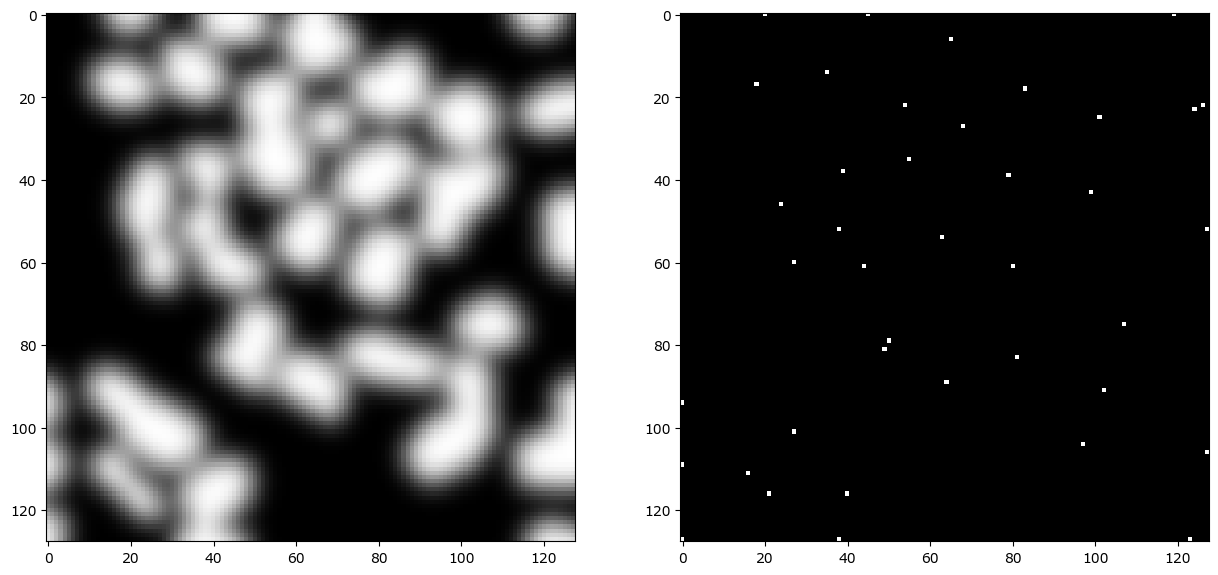

In [79]:
# voronoi and otsu

import sys
import cv2
from matplotlib import pyplot as plt
import pyclesperanto_prototype as cle
from skimage import io

# heavy gaussian blurring assists in detecting maxima that reflects the objects.
#If objects are closer, you may want to decrease the amount of blurring.
img_gaussian = cle.gaussian_blur(lamellipodia, sigma_x=3, sigma_y=3, sigma_z=3)
plt.imshow(img_gaussian, cmap='gray')

# Find out the maxima locations for each 'blob'
img_maxima_locations = cle.detect_maxima_box(img_gaussian, radius_x=0, radius_y=0, radius_z=0)

#Number of maxima locations (= number of objects)
#This number depend on the amount of Gaussian blur
number_of_maxima_locations = cle.sum_of_all_pixels(img_maxima_locations)
print("number of detected maxima locations", number_of_maxima_locations)

#View the blurred image and corresponding maxima locations
fig, axs = plt.subplots(1, 2, figsize=(15, 15))
cle.imshow(img_gaussian, plot=axs[0], color_map='gray')
cle.imshow(img_maxima_locations, plot=axs[1], color_map='gray')


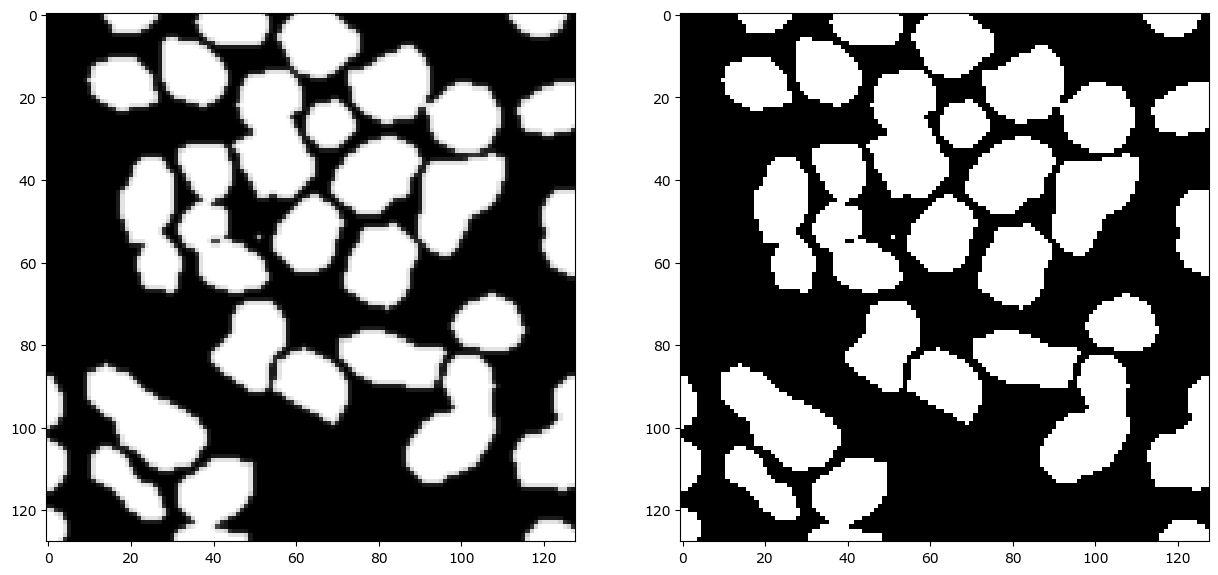

In [80]:
#Step 2: threshold the input image after applying light gaussian blur (sigma=1)
img_gaussian2 = cle.gaussian_blur(lamellipodia, sigma_x=0.5, sigma_y=0.5, sigma_z=0.5)
img_thresh = cle.threshold_otsu(img_gaussian2)

fig, axs = plt.subplots(1, 2, figsize=(15, 15))
cle.imshow(img_gaussian2, plot=axs[0], color_map='gray')
cle.imshow(img_thresh, plot=axs[1], color_map='gray')

number of relevant maxima locations 40.0


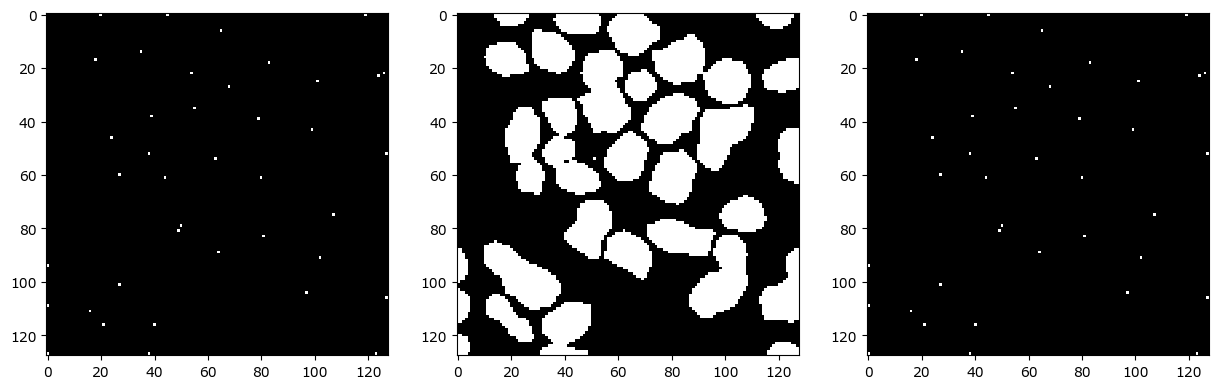

In [81]:
#Step 3: Exclude maxima locations from the background, to make sure we only include the ones from nuclei
# We can do this by using binary and operation
img_relevant_maxima = cle.binary_and(img_thresh, img_maxima_locations)

number_of_relevant_maxima_locations = cle.sum_of_all_pixels(img_relevant_maxima)
print("number of relevant maxima locations", number_of_relevant_maxima_locations)


fig, axs = plt.subplots(1, 3, figsize=(15, 15))
cle.imshow(img_maxima_locations, plot=axs[0], color_map='gray')
cle.imshow(img_thresh, plot=axs[1], color_map='gray')
cle.imshow(img_relevant_maxima, plot=axs[2], color_map='gray')

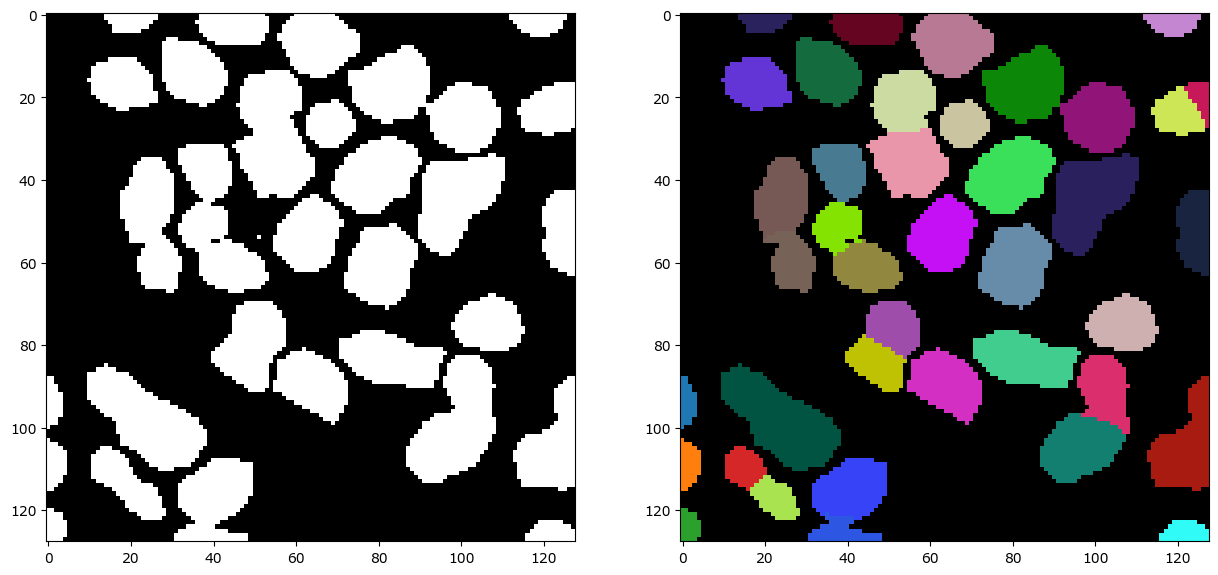

In [82]:
#Step 4: Separate maxima locations into labels using masked voronoi
voronoi_separation = cle.masked_voronoi_labeling(img_relevant_maxima, img_thresh)

fig, axs = plt.subplots(1, 2, figsize=(15, 15))
cle.imshow(lamellipodia, plot=axs[0], color_map='gray')
cle.imshow(voronoi_separation, labels=True, plot=axs[1])